In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
import numpy as np

/Users/sammamsohail/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

## data preprocessing and splitting
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_path = 'dataset/'

train_dataset = train_datagen.flow_from_directory(train_path, 
                                               target_size=IMG_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

test_dataset = train_datagen.flow_from_directory(train_path, 
                                           target_size=IMG_SIZE,
                                           batch_size=BATCH_SIZE,
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 70306 images belonging to 38 classes.
Found 17561 images belonging to 38 classes.


In [13]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))  ## VGG19 pretrained models

## Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x) 
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_dataset.num_classes, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

## Close base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## model training
history = model.fit(
    train_dataset,
    epochs=3,
    verbose=1
)

Epoch 1/3
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 324s 146ms/step - accuracy: 0.6873 - loss: 1.0617
Epoch 2/3
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 321s 146ms/step - accuracy: 0.8108 - loss: 0.5929
Epoch 3/3
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 321s 146ms/step - accuracy: 0.8354 - loss: 0.5078


In [14]:
model.save('model.h5')

In [15]:
model = load_model('model.h5')

549/549 ━━━━━━━━━━━━━━━━━━━━ 79s 143ms/step - accuracy: 0.8828 - loss: 0.3772
Test accuracy: 0.8714


## Testing the model

In [16]:
import numpy as np


predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)


549/549 ━━━━━━━━━━━━━━━━━━━━ 76s 138ms/step


In [17]:
from sklearn.metrics import accuracy_score

true_labels = test_dataset.classes
accuracy = accuracy_score(true_labels, predicted_classes)
print('Accuracy:', accuracy)

Accuracy: 0.8714765673936564


In [18]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       504
           1       0.97      0.69      0.80       496
           2       0.85      0.93      0.89       440
           3       0.93      0.82      0.87       502
           4       0.85      0.92      0.88       454
           5       0.81      0.96      0.88       420
           6       0.90      0.96      0.93       456
           7       0.88      0.83      0.85       410
           8       0.99      0.97      0.98       476
           9       0.88      0.92      0.90       477
          10       0.99      1.00      0.99       464
          11       0.87      0.89      0.88       472
          12       0.90      0.89      0.90       480
          13       0.94      0.98      0.96       430
          14       0.90      0.97      0.93       423
          15       0.95      0.99      0.97       502
          16       0.92      0.90      0.91       459
          17       0.93    

## ROC-AUC curve

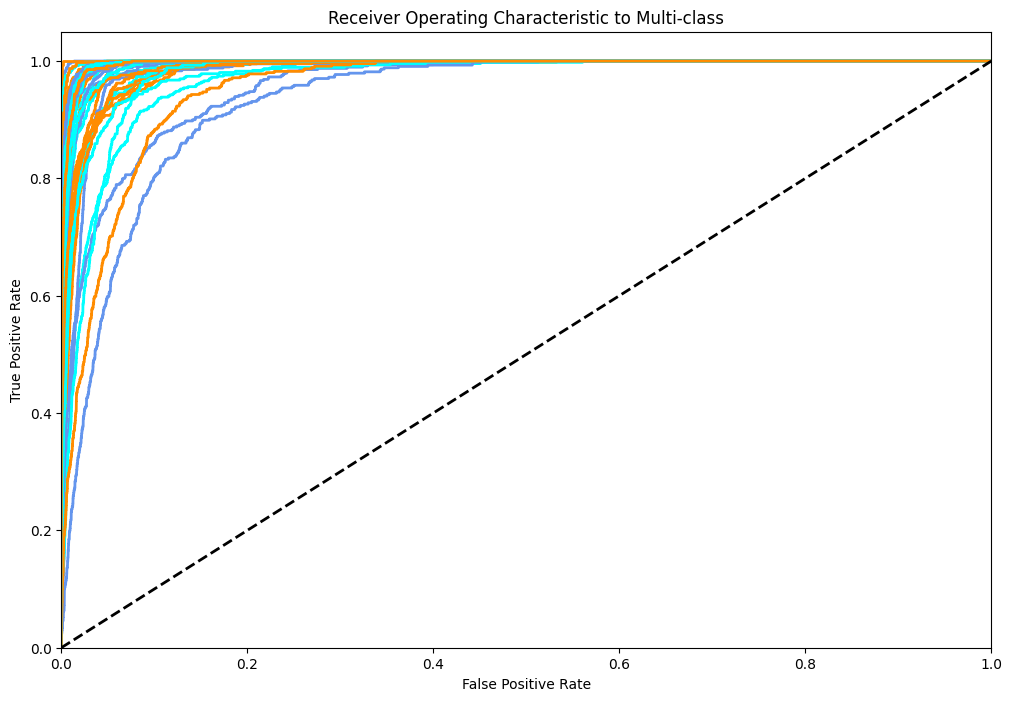

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_roc_auc(y_true, y_pred_proba, n_classes):

    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(12, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic to Multi-class')
    plt.show()

plot_roc_auc(test_dataset.classes, predictions, test_dataset.num_classes)